# Dimensionality reduction with cisTopic

Using inline R magic

In [2]:
import numpy as np
import scanpy as sc 
import pandas as pd
import anndata

### r2py set-up

In [3]:
import rpy2.rinterface_lib.callbacks
import logging

In [4]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

I use `anndata2ri` to handle conversion of the sparse matrix (not too straightforward with `rpy2` alone)

In [5]:
import anndata2ri
anndata2ri.activate()

Loading the `rpy2` extension enables cell magic to be used. This runs R code in jupyter notebook cells.

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R
## Install dependencies
# devtools::install_github("aertslab/RcisTarget")
# devtools::install_github("aertslab/AUCell")
        
# devtools::install_github("aertslab/cisTopic")
library(cisTopic)
library(Matrix)

### Load data

In [8]:
outdir = "/home/jovyan/data/lung_adult_scATAC/"
experiment_prefix = 'lungAdult_'

In [9]:
adata = sc.read_h5ad(outdir + experiment_prefix + '_ATAC_raw.h5ad')

### Set-up for cisTopic

In [10]:
# # (Trying just on a subset to test the code quickly)
# # Don't run this on your data
# adata = adata[0:5000, 0:10000]

Remove empty rows

In [11]:
adata = adata[:,adata.X.sum(0) > 0]

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [12]:
adata

View of AnnData object with n_obs × n_vars = 53585 × 96161
    obs: 'cellatac_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

Convert `anndata` object to `SingleCellExperiment` (conversion cab take a while)

In [13]:
# adata.X = adata.layers["binary_raw"]

In [14]:
# adata.obs["cellatac_clusters"] = adata.obs["cellatac_clusters"].astype("int")

In [15]:
%%R -i adata
adata

class: SingleCellExperiment 
dim: 96161 53585 
metadata(0):
assays(2): X binary_raw
rownames(96161): chr1:816942-817444 chr1:826600-827805 ...
  chrY:21574860-21575895 chrY:22366897-22367799
rowData names(15): peak_width exon ... total_counts log1p_total_counts
colnames(53585): 59-AAACGAAAGATATGAC-1 59-AAACGAAAGGTAGGAA-1 ...
  04-TTTGTGTTCGGATAGG-1 04-TTTGTGTTCTCGTAGA-1
colData names(9): cellatac_clusters n_genes_by_counts ...
  pct_counts_in_top_200_genes pct_counts_in_top_500_genes
reducedDimNames(0):
spikeNames(0):
altExpNames(0):


### Train cisTopic models

In [15]:
%%R 

# Initialize cisTopic object 
cisTopicObject <- createcisTopicObject(
    assay(adata, "X"),
    project.name='ATAC_cisTopic')

cisTopicObject

From cffi callback <function _processevents at 0x7f9582438200>:
Traceback (most recent call last):
  File "/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/rinterface_lib/callbacks.py", line 267, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt


An object of class cisTopic in project ATAC_cisTopic 
 96161 regions across 53585 samples.


In [35]:
%%R -i outdir -i experiment_prefix
## Run models (updated to cisTopic v3) ##
# topics_vec <- c(30:50, 60, 70, 80, 90, 100)
topics_vec <- c(40)
cisTopicObject <- runWarpLDAModels(cisTopicObject, topic=topics_vec, 
                                   seed=42, 
                                   nCores=5, 
                                   iterations = 500
                                  )

## Save trained models
saveRDS(cisTopicObject, paste0(outdir, experiment_prefix, "ATAC.trainedCistopic.RDS"))

INFO  [20:52:10.046] early stopping at 50 iteration 


In [16]:
%%R -i outdir -i experiment_prefix
cisTopicObject <- readRDS(paste0(outdir, experiment_prefix, "ATAC.trainedCistopic.RDS"))

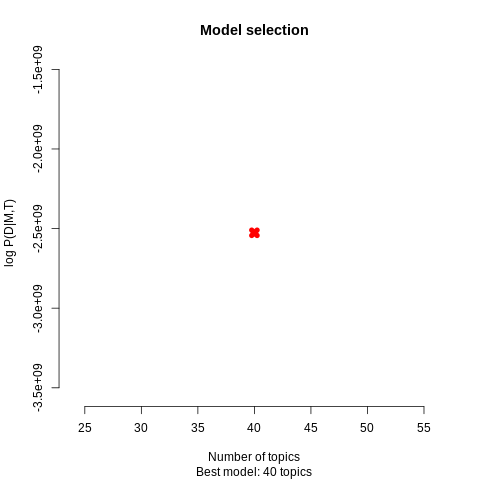

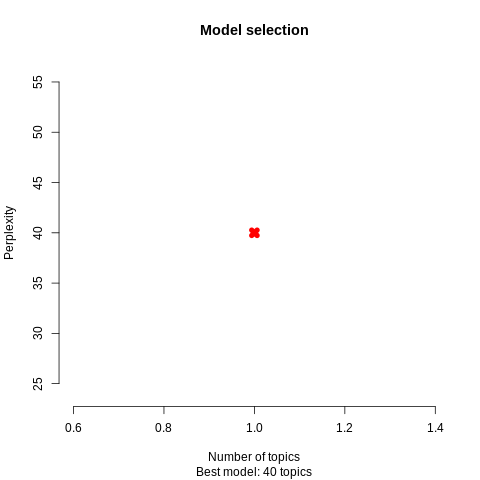

In [17]:
%%R

## Select model ##
cistopic_model <- selectModel(cisTopicObject, type="maximum")

In [18]:
%%R -o topicXcell
## Save topic matrix ##
topicXcell <- modelMatSelection(cistopic_model, 'cell', 'Probability')

dim(topicXcell)

[1]    40 53585


In [19]:
adata.obsm['X_cistopic'] = topicXcell.T

### Visualize dim reduction results

In [20]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep="X_cistopic")

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/jovyan/.local/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/jovyan/.local/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../home/jovyan/.lo

In [21]:
sc.tl.umap(adata)

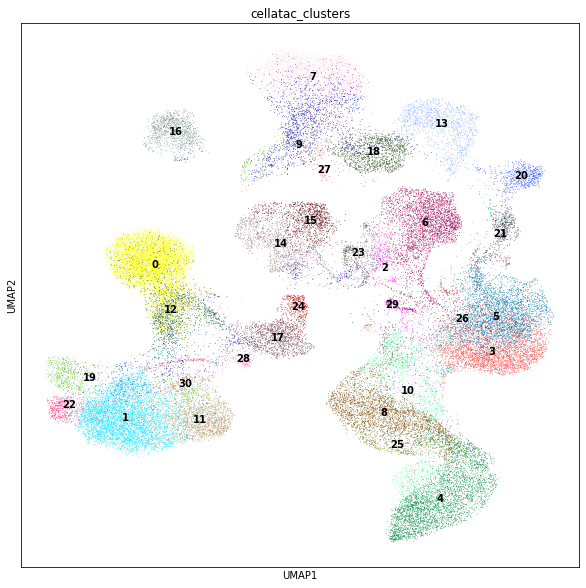

In [22]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,10]
adata.obs["cellatac_clusters"] = adata.obs["cellatac_clusters"].astype("category")
sc.pl.umap(adata, color="cellatac_clusters", legend_loc="on data")

In [23]:
sc.pp.calculate_qc_metrics(adata, layer="binary_raw", inplace=True)

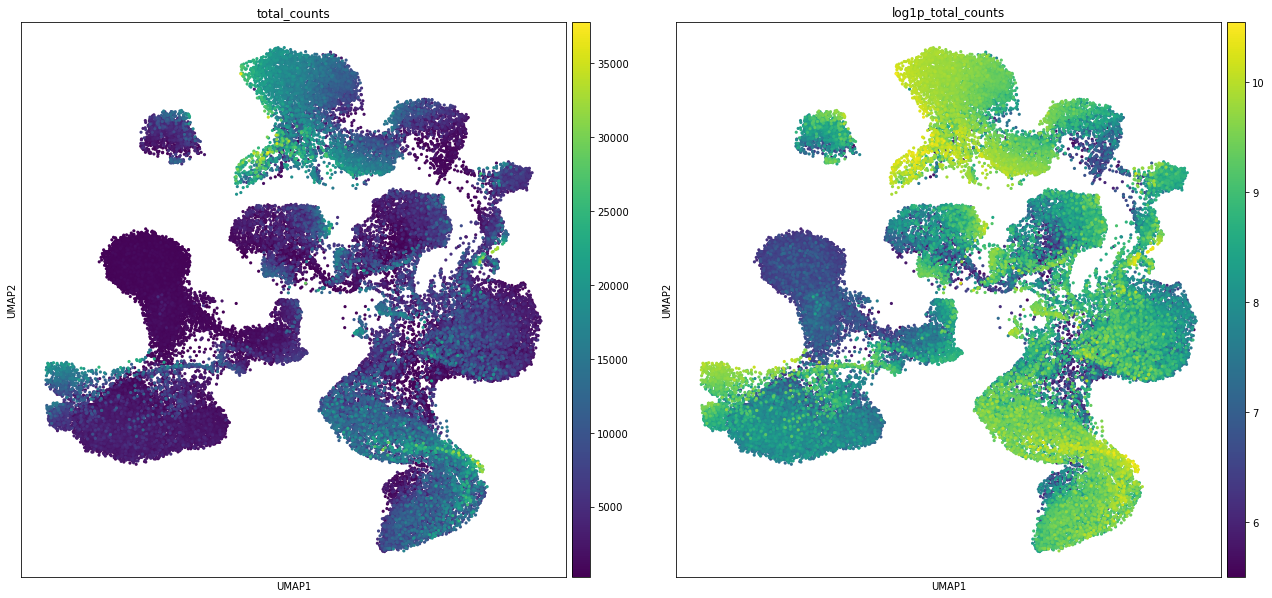

In [24]:
sc.pl.umap(adata, color=['total_counts',"log1p_total_counts"], size=40, legend_loc="on data")

### De-noising the peak x cell matrix with cisTopic

The learnt LDA model from cisTopic can be used to generate a de-noised accessibility matrix. From the [paper](https://www.nature.com/articles/s41592-019-0367-1):

> cisTopic calculates the predictive distribution, which describes
the probability of each region in each cell, by multiplying the topic–cell and the
region–topic distributions:
$$
P(r_i|c_j) = \sum_{k=1}^{K}{P(r_i|T_k)P(T_k|c_j)}
$$

where
> - $P(r_i | c_j)$ is the probability of region i in cell j,
> - $P(r_i | T_k)$ is the probability of region i in topic k, and
> - $P(T_k | c_j)$ is the probability of topic k in cell j.


Export the region x topic probability matrix

In [25]:
%%R -o alpha -o beta -o doc_expects -o topics
alpha <- cistopic_model@calc.params[['runWarpLDAModels']]$alpha
beta <- cistopic_model@calc.params[['runWarpLDAModels']]$beta
doc_expects <- cistopic_model@selected.model$document_expects
topics <- cistopic_model@selected.model$topics

In [26]:
# smoothed.topics <- as.big.matrix(t((topics + beta)/Matrix::rowSums(topics + beta)))
smoothed_topics = (topics + beta)/sum(topics + beta, 1)


In [27]:
p_mat = np.dot(smoothed_topics.T, doc_expects)

In [28]:
adata.layers["cistopic_p"] = p_mat.T

In [ ]:
adata.write_h5ad(outdir + experiment_prefix + "_ATAC.wCisTopic.h5ad")

### Calculate de-noised gene scores

The de-noised accessibility signal can be used to calculate a gene-level accessibility scores (first implemented in [Bravo Gonzales-Blas et al. 2020](https://www.embopress.org/doi/full/10.15252/msb.20209438)). This is very useful to check out accessibility of marker genes for example. From the paper:

> we first multiply the region‐topic and topic‐cell distributions to obtain a region‐cell distribution, which indicates the probability of accessibility of each region in each cell. Then, for each gene, we aggregate the probabilities of the surrounding regions (in this case, 5 kb around the TSS plus introns), resulting in a gene activity score

At the moment there is no specific function in cisTopic to do this, but here is a simple implementation using functionality in `GenomicRanges` and `Signac`. Here I use peaks within a 5kb window of a gene (`d` parameter)

In [ ]:
%%R 
library(GenomicRanges)
library(ensembldb)
library(EnsDb.Hsapiens.v86)
library(tidyr)
library(SingleCellExperiment)
# library(Signac)

In [ ]:
%%R
## String - GRanges conversion
## Borrowed from Signac functions 
## https://satijalab.org/signac/reference/GRangesToString.html
StringToGRanges <- function(regions, sep = c("-", "-"), ...) {
  ranges.df <- data.frame(ranges = regions)
  ranges.df <- separate(
    data = ranges.df,
    col = "ranges",
    sep = paste0(sep[[1]], "|", sep[[2]]),
    into = c("chr", "start", "end")
  )
  granges <- makeGRangesFromDataFrame(df = ranges.df, ...)
  return(granges)
}

GRangesToString <- function(grange, sep = c("-", "-")) {
  regions <- paste0(
    as.character(x = seqnames(x = grange)),
    sep[[1]],
    start(x = grange),
    sep[[2]],
    end(x = grange)
  )
  return(regions)
}

# Extend genomicRanges
# 
extend <- function(x, upstream=0, downstream=0)     
{
    if (any(strand(x) == "*"))
        warning("'*' ranges were treated as '+'")
    on_plus <- strand(x) == "+" | strand(x) == "*"
    new_start <- start(x) - ifelse(on_plus, upstream, downstream)
    new_end <- end(x) + ifelse(on_plus, downstream, upstream)
    ranges(x) <- IRanges(new_start, new_end)
    trim(x)
}


# Find peaks close to features of interest
#
# @param peaks_gr GenomicRanges object containing peaks
# @param features_gr GenomicRanges object containing features (e.g. genes)
# @param d distance to include peak, in bps (default 50000)
# @param feat_anno column in `features_gr@elementMetadata` containing annotation to name features (if NULL converts Granges to string)
#
# @return Sparse adjacency matrix indicating hits
peak2feature <- function(peaks_gr, features_gr, d=50000, feat_anno=NULL){
  seqlevelsStyle(features_gr) <- seqlevelsStyle(peaks_gr)
  
  ## Find peaks overlapping the search range around the features
  ext_gr <- extend(features_gr, upstream = d, downstream = d)
  ovs <- findOverlaps(peaks_gr, ext_gr)
  
  ## Define identifiers for peaks and features
  all_peaks <- GRangesToString(peaks_gr, sep = c(":", '-'))
  if (is.null(feat_anno)) {
    all_feats <- GRangesToString(features_gr, sep = c(":", '-'))
  } else {
    all_feats <- features_gr@elementMetadata[[feat_anno]]
  }
  
  ## Build adjacency matrix for hits
  adj_mat <- Matrix(data=0, nrow = length(all_peaks), ncol=length(all_feats))
  for (i in unique(subjectHits(ovs))) {
    # if (length(adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i]) > 0) {
    adj_mat[queryHits(ovs[subjectHits(ovs)==i]),i] <- 1
    # }
  }
  colnames(adj_mat) <- all_feats
  rownames(adj_mat) <- all_peaks
  
  adj_mat
  
}

In [ ]:
%%R
genes_gr <- genes(EnsDb.Hsapiens.v86)
peaks_gr <- StringToGRanges(rownames(assay(adata, "X")), sep=c(":", "-"))

In [ ]:
%%R -o adj_mat
## Compute peak2gene adjacency matrix
adj_mat <- peak2feature(peaks_gr, genes_gr, feat_anno = "gene_id", d=5000)

# Filter genes with at least 3 peaks in the proximity
keep.genes <- which(colSums(adj_mat) > 2) 
adj_mat <- t(adj_mat[,keep.genes])

In [ ]:
%%R -o gene_var
head(rownames(adj_mat))
genes <- rownames(adj_mat)
gene_var <- genes_gr[genes,]@elementMetadata[c("gene_id","gene_name")]

In [ ]:
gene_mat = adj_mat.dot(p_mat)

Then you can save another anndata object with the same `.obs` as the original one, but storing the gene score info.

In [ ]:
gene_adata = anndata.AnnData(X=gene_mat.T, 
                             obs=adata.obs, 
                             var=gene_var)
gene_adata.var_names = gene_adata.var["gene_id"]
gene_adata

### Save anndata objects

In [ ]:
gene_adata.write_h5ad(outdir + experiment_prefix + "_ATAC.geneScores.h5ad")